In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

In [0]:
np.random.seed(101)
tf.set_random_seed(101)

## Dataset
We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 


In [3]:
from keras.datasets import cifar10

(X, y), (X_test, y_test) = cifar10.load_data()

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print('')
print(X_val.shape)
print(y_val.shape)
print('')
print(X_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(40000, 32, 32, 3)
(40000, 1)

(10000, 32, 32, 3)
(10000, 1)

(10000, 32, 32, 3)
(10000, 1)


In [4]:
# not normalized
print(X_train[0].max())
print(X_train[0].min())

248
24


[6]


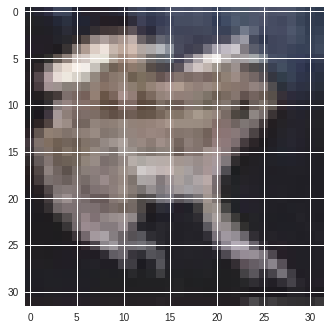

In [5]:
# Sample
display(plt.imshow(X_train[0]))
print(y_train[0])

## Feature Engineering 

In [6]:
# Normalize X
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Reshape tensor
X_train_rs = X_train_norm.reshape(-1, 32, 32, 3)
X_val_rs = X_val_norm.reshape(-1, 32, 32, 3)
X_test_rs = X_test_norm.reshape(-1, 32, 32, 3)

print(X_train_rs.shape)
print(X_val_rs.shape)
print(X_test_rs.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
# One hot encoding y
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print(y_train_cat.shape)
print(y_val_cat.shape)
print(y_test_cat.shape)

(40000, 10)
(10000, 10)
(10000, 10)


## Model - Keras

In [8]:
# Equivalent Keras Model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Activation, Dropout
import keras.backend as K

K.clear_session()

model = Sequential()

# Feature Extraction layers
model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Activation('relu'))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(10, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          36928     
__________

## Model - Tensorflow

In [0]:
tf.reset_default_graph()

In [0]:
def init_weights(shape):
    """Init weight"""
    # Random normal distribution
    init_random_dist = tf.truncated_normal(
        shape, 
        stddev=0.1)
    return tf.Variable(init_random_dist)


def init_bias(shape):
    """Init bias"""
    # Constant 0.1
    init_bias_vals = tf.constant(
        0.1,
        shape=shape)
    return tf.Variable(init_bias_vals)

In [0]:
def conv2d(x, W):
    # x tensor: [batch, H, W, C]
    # W tensor: [filter H, filter W, Cin, Cout]
    return tf.nn.conv2d(
        x, W,
        strides=[1, 1, 1, 1], 
        padding='SAME')


def conv_layer(x, shape):
    # [filter H, filter W, Cin, Cout]
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(x, W) + b)


def max_pool_2by2_layer(x):
    # tensor x: [batch, H, W, C]
    return tf.nn.max_pool(
        x, 
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='SAME')


def dense_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [12]:
# Placeholders
X_ph = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_ph = tf.placeholder(tf.float32,shape=[None,10])
dropout_ph = tf.placeholder(tf.float32) # Dropout params

###################################### Stack layers ###############################################
# Feature Extraction layers
convo_1 = conv_layer(
    X_ph,
    shape=[5,5,3,32])
convo_1_pooling = max_pool_2by2_layer(convo_1)

convo_2 = conv_layer(
    convo_1_pooling,
    shape=[5,5,32,32])
convo_2_pooling = max_pool_2by2_layer(convo_2)

convo_3 = conv_layer(
    convo_2_pooling,
    shape=[3,3,32,64])
convo_3_pooling = max_pool_2by2_layer(convo_3)

convo_4 = conv_layer(
    convo_3_pooling,
    shape=[3,3,64,64])
convo_4_pooling = max_pool_2by2_layer(convo_4)

# Flatten layer
convo_2_flat = tf.reshape(convo_4_pooling,[-1, 2*2*64])

# Fully connected layers
dense_layer_1 = tf.nn.relu(
    dense_layer(convo_2_flat, 1024))

dense_layer_2 = tf.nn.relu(
    dense_layer(dense_layer_1, 512))

dense_one_dropout = tf.nn.dropout(
    dense_layer_2,
    keep_prob=dropout_ph)

y_pred = dense_layer(dense_one_dropout, 10)
###################################################################################################

# Loss function
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_ph,
        logits=y_pred))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

# trainning function
train = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
def next_batch(X, y, batch_size=10):
    # Select a random batch index
    rand_idx = np.random.randint(
        len(X),
        size=batch_size)

    return X[rand_idx], y[rand_idx]

In [14]:
# Init Variables
init = tf.global_variables_initializer()

# GPU option
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# Saver
saver = tf.train.Saver()

# Epochs
epochs = 10001

# Accuracies
train_accs = []
val_accs = []

# Losses
train_losses = []
val_losses = []

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # Init Variables
    sess.run(init)
    
    # Run epochs
    for i in range(epochs):
        # Select a random batch
        X_batch , y_batch = next_batch(
            X_train_rs , y_train_cat,
            batch_size=64)

        # Train
        sess.run(
            train,
            feed_dict={
                X_ph: X_batch,
                y_ph: y_batch,
                dropout_ph: 0.8})
        
        if i%100 == 0:
            # Train acc
            train_matches = tf.equal(
                tf.argmax(y_batch, 1),
                tf.argmax(y_pred, 1))

            train_accuracy = tf.reduce_mean(tf.cast(train_matches,tf.float32))

            train_acc = sess.run(
                train_accuracy,
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch,
                    dropout_ph:1.0})

            train_accs.append(train_acc)
            
            # Train loss
            train_loss = loss.eval(
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch,
                    dropout_ph: 1.0})
            train_losses.append(train_loss)
            
            # Val acc
            val_matches = tf.equal(
                tf.argmax(y_val_cat, 1),
                tf.argmax(y_pred, 1))

            val_accuracy = tf.reduce_mean(tf.cast(val_matches,tf.float32))

            val_acc = sess.run(
                val_accuracy,
                feed_dict={
                    X_ph: X_val_rs,
                    y_ph: y_val_cat,
                    dropout_ph: 1.0})

            val_accs.append(val_acc)
            
            # Val loss
            val_loss = loss.eval(
                feed_dict={
                    X_ph: X_val_rs,
                    y_ph: y_val_cat,
                    dropout_ph: 1.0})
            val_losses.append(val_loss)

            # PRINT OUT A MESSAGE EVERY 500 STEPS
            if i%500 == 0:
                print('Epoch {}'.format(i))
                print('train_acc = {} - val_acc = {}'.format(train_acc, val_acc))
                print('train_loss = {} - val_loss = {}\n'.format(train_loss, val_loss))

    # SAVE MODEL
    saver.save(sess, 'my_model/CIFAR_CNN.ckpt')

Epoch 0
train_acc = 0.046875 - val_acc = 0.10260000079870224
train_loss = 7.801501274108887 - val_loss = 7.4086127281188965

Epoch 500
train_acc = 0.390625 - val_acc = 0.4066999852657318
train_loss = 1.5893349647521973 - val_loss = 1.6387531757354736

Epoch 1000
train_acc = 0.5 - val_acc = 0.4632999897003174
train_loss = 1.2828515768051147 - val_loss = 1.4912986755371094

Epoch 1500
train_acc = 0.453125 - val_acc = 0.4733000099658966
train_loss = 1.5404963493347168 - val_loss = 1.4447191953659058

Epoch 2000
train_acc = 0.5625 - val_acc = 0.5051000118255615
train_loss = 1.312830924987793 - val_loss = 1.3668102025985718

Epoch 2500
train_acc = 0.53125 - val_acc = 0.5335999727249146
train_loss = 1.2340424060821533 - val_loss = 1.313109040260315

Epoch 3000
train_acc = 0.53125 - val_acc = 0.5389000177383423
train_loss = 1.039574384689331 - val_loss = 1.2918802499771118

Epoch 3500
train_acc = 0.625 - val_acc = 0.5493999719619751
train_loss = 1.172863483428955 - val_loss = 1.28066229820251

Text(0.5,0,'Epochs')

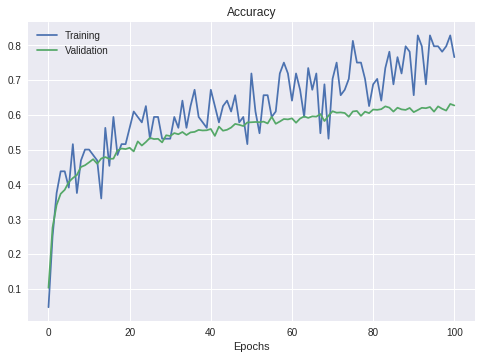

In [15]:
plt.plot(train_accs)
plt.plot(val_accs)

plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

Text(0.5,0,'Epochs')

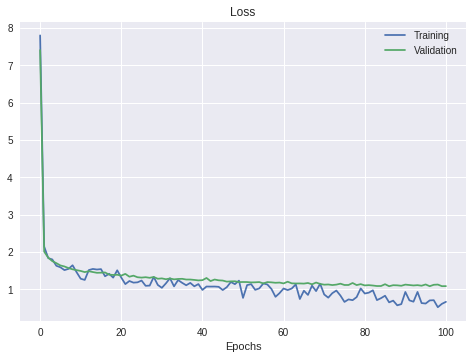

In [16]:
plt.plot(train_losses)
plt.plot(val_losses)

plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epochs')

## Evaluate Test

In [17]:
with tf.Session() as sess:
    # Restore the model
    saver.restore(sess,'my_model/CIFAR_CNN.ckpt')
    
    # Test accuracy
    test_matches = tf.equal(
        tf.argmax(y_test_cat, 1),
        tf.argmax(y_pred, 1))

    test_accuracy = tf.reduce_mean(tf.cast(test_matches,tf.float32))

    test_acc = sess.run(
        test_accuracy,
        feed_dict={
            X_ph: X_test_rs,
            y_ph: y_test_cat,
            dropout_ph:1.0})

    print('Test set accuracy: ', test_acc)

INFO:tensorflow:Restoring parameters from my_model/CIFAR_CNN.ckpt
Test set accuracy:  0.6225
